In [1]:
from IPython.display import HTML

In [2]:
HTML(
    '''
    <script>
    code_show=true; 
    function code_toggle() {
     if (code_show){
     $('div.input').hide();
     } else {
     $('div.input').show();
     }
     code_show = !code_show
    } 
    $( document ).ready(code_toggle);
    </script>
    <a href="javascript:code_toggle()">TOGGLE CODE ON/OFF</a>
    '''
)

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Sanity-checks-on-motion-energy" data-toc-modified-id="Sanity-checks-on-motion-energy-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Sanity checks on motion energy</a></span></li></ul></div>

__Aims:__
- reads off trials from the HDF5 db in order to compute motion energy
- explore a few statistics of ME within groups of trials (e.g. 0-coh trials)
- plots reverse kernels

Constants and settings

In [1]:
import sys

# add location of custom modules to path
sys.path.insert(0,'../modules/')
sys.path.insert(0,'../modules/dots_db/dotsDB/')

# add location of data to path -- I couldn't make this work
# sys.path.insert(0,'../../data/')
# sys.path.insert(0,'../modules/dots_db/data/')

In [2]:
# pip modules
import pprint
import numpy as np             
import pandas as pd    
import seaborn as sns
import matplotlib.pyplot as plt
import h5py     

# custom modules
import dotsDB as ddb
import motionenergy as kiani_me
import stimulus as stim
import ME_functions as my_me

In [3]:
# OPTIONS AND CONSTANTS
%matplotlib inline

sns.set(style="darkgrid", context="poster")
TITLE_FS = 22
AXES_FS = 22
plt.rcParams.update({'font.size': AXES_FS}) # font size on axes
plt.subplots_adjust(wspace=0.5) # horizontal space between panels

SKIP_BASIC_STEPS = False

<Figure size 432x288 with 0 Axes>

Load all group and dataset names in DB

In [7]:
# options are, for now
# '../../data/pilot11.h5'
# '../modules/dots_db/data/test.h5'
# '../modules/dots_db/data/test2.h5'
file_path = '/home/adrian/SingleCP_DotsReversal/processed/pilot_v3.h5'

database_info = ddb.inspect_db(file_path)
# print('INSPECTING DATABASE:')
object_names = []  # list of object names in database
idx = 0
for l1 in database_info.keys():
    curr_d = database_info[l1]
    
    if (curr_d['attrs'] and curr_d['type'] == 'group') or (curr_d['type']=='dataset' and curr_d['shape'][0]>0):
        object_names.append(l1)
#         print(f"\n Object name {idx}: {l1}")  # print initial group names separately because they are extremely long
#         pprint.pprint(database_info[l1], width=60)
        idx += 1

In [8]:
pprint.pprint(object_names)

['subjS1/probCP0.0/coh0.0/ansleft/CPno/VD100/left',
 'subjS1/probCP0.0/coh0.0/ansleft/CPno/VD100/left/px',
 'subjS1/probCP0.0/coh0.0/ansleft/CPno/VD100/right',
 'subjS1/probCP0.0/coh0.0/ansleft/CPno/VD100/right/px',
 'subjS1/probCP0.0/coh0.0/ansleft/CPno/VD200/left',
 'subjS1/probCP0.0/coh0.0/ansleft/CPno/VD200/left/px',
 'subjS1/probCP0.0/coh0.0/ansleft/CPno/VD200/right',
 'subjS1/probCP0.0/coh0.0/ansleft/CPno/VD200/right/px',
 'subjS1/probCP0.0/coh0.0/ansleft/CPno/VD300/left',
 'subjS1/probCP0.0/coh0.0/ansleft/CPno/VD300/left/px',
 'subjS1/probCP0.0/coh0.0/ansleft/CPno/VD300/right',
 'subjS1/probCP0.0/coh0.0/ansleft/CPno/VD300/right/px',
 'subjS1/probCP0.0/coh0.0/ansleft/CPno/VD400/left',
 'subjS1/probCP0.0/coh0.0/ansleft/CPno/VD400/left/px',
 'subjS1/probCP0.0/coh0.0/ansleft/CPno/VD400/right',
 'subjS1/probCP0.0/coh0.0/ansleft/CPno/VD400/right/px',
 'subjS1/probCP0.0/coh0.0/ansright/CPno/VD100/left',
 'subjS1/probCP0.0/coh0.0/ansright/CPno/VD100/left/px',
 'subjS1/probCP0.0/coh0.0/a

Now, I will need to group datasets by factor values. Examples of grouping are:
- 0-coh trials with true direction L vs R, VD 400, CP vs noCP

In [23]:
vals = {k: None for k in ['subject', 'pcp', 'coh', 'ans', 'cp', 'vd', 'dir']}
my_round = (lambda x: str(round(float(x), 1)))
maps = {
    'subject': {i: 'subjS' + str(i) for i in [1, 2, 3, 4, 5]},
    'pcp': {k: 'probCP' + my_round(k) for k in [0, 0.2, 0.5, 0.8]},
    'coh': {0: 'coh0.0', 100: 'coh100.0', 'fcn': my_round},
    'ans': {'l': 'ansleft', 'r': 'ansright'},
    'cp': {True: 'CPyes', False: 'CPno'},
    'vd': {k: 'VD' + str(k) for k in [100, 200, 300, 400]},
    'dir': {k: '/' + k for k in ['left', 'right']}
}
pprint.pprint(maps)

{'ans': {'l': 'ansleft', 'r': 'ansright'},
 'coh': {0: 'coh0.0',
         100: 'coh100.0',
         'fcn': <function <lambda> at 0x7f44eee3fea0>},
 'cp': {False: 'CPno', True: 'CPyes'},
 'dir': {'left': '/left', 'right': '/right'},
 'pcp': {0: 'probCP0.0', 0.2: 'probCP0.2', 0.5: 'probCP0.5', 0.8: 'probCP0.8'},
 'subject': {1: 'subjS1', 2: 'subjS2', 3: 'subjS3', 4: 'subjS4', 5: 'subjS5'},
 'vd': {100: 'VD100', 200: 'VD200', 300: 'VD300', 400: 'VD400'}}


In [15]:
s = 'jflkjds/px'
s[-3:]

'/px'

In [24]:
def get_names(restr_vals, name_list):
    """
    This function returns a tuple of lists of names.
    First list is for groups, second list is for datasets.
    The purpose is to filter only the names corresponding to the restricted values in restr_vals.
    Values in the dict restr_vals should be iterables (e.g. lists). Keys in restr_vals should be in maps.keys()
    """
    dsets = []
    groups = []
    for name in name_list:
        keep = True
        for k, v in restr_vals.items():
            if all([maps[k][val] not in name for val in v]):
                keep = False
                break      
        if keep:
            if name[-3:] == '/px':
                dsets.append(name)
            else:
                groups.append(name)
    return groups, dsets

In [28]:
g, d = get_names({'ans': ['l'], 'coh': [0], 'dir': ['left'], 'vd': [400], 'cp': [False]}, object_names)

In [29]:
pprint.pprint(g)

['subjS1/probCP0.0/coh0.0/ansleft/CPno/VD400/left',
 'subjS2/probCP0.0/coh0.0/ansleft/CPno/VD400/left',
 'subjS2/probCP0.2/coh0.0/ansleft/CPno/VD400/left',
 'subjS2/probCP0.5/coh0.0/ansleft/CPno/VD400/left',
 'subjS3/probCP0.0/coh0.0/ansleft/CPno/VD400/left',
 'subjS3/probCP0.2/coh0.0/ansleft/CPno/VD400/left',
 'subjS3/probCP0.5/coh0.0/ansleft/CPno/VD400/left',
 'subjS4/probCP0.0/coh0.0/ansleft/CPno/VD400/left',
 'subjS5/probCP0.0/coh0.0/ansleft/CPno/VD400/left',
 'subjS5/probCP0.2/coh0.0/ansleft/CPno/VD400/left',
 'subjS5/probCP0.5/coh0.0/ansleft/CPno/VD400/left']


In [30]:
pprint.pprint(d)

['subjS1/probCP0.0/coh0.0/ansleft/CPno/VD400/left/px',
 'subjS2/probCP0.0/coh0.0/ansleft/CPno/VD400/left/px',
 'subjS2/probCP0.2/coh0.0/ansleft/CPno/VD400/left/px',
 'subjS2/probCP0.5/coh0.0/ansleft/CPno/VD400/left/px',
 'subjS3/probCP0.0/coh0.0/ansleft/CPno/VD400/left/px',
 'subjS3/probCP0.2/coh0.0/ansleft/CPno/VD400/left/px',
 'subjS3/probCP0.5/coh0.0/ansleft/CPno/VD400/left/px',
 'subjS4/probCP0.0/coh0.0/ansleft/CPno/VD400/left/px',
 'subjS5/probCP0.0/coh0.0/ansleft/CPno/VD400/left/px',
 'subjS5/probCP0.2/coh0.0/ansleft/CPno/VD400/left/px',
 'subjS5/probCP0.5/coh0.0/ansleft/CPno/VD400/left/px']


In [26]:
# a='subjS1/probCP0.0/coh0.0/ansleft/CPno/VD100/left'
group_names=[
    '/subjS1/probCP0.0/coh0.0/ansleft/CPno/VD400/left',
    '/subjS1/probCP0.0/coh18.5/ansleft/CPno/VD400/left',
    '/subjS2/probCP0.0/coh100.0/ansleft/CPno/VD400/left',
    '/subjS2/probCP0.2/coh0.0/ansright/CPyes/VD400/right',
    '/subjS2/probCP0.2/coh100.0/ansright/CPyes/VD400/right',
    '/subjS2/probCP0.2/coh24.5/ansleft/CPyes/VD400/right'
]
dset_names=[s + '/px' for s in group_names]

In [21]:
# group_names, dset_names = [], []
# for n in object_names:
#     if n[-13:] == 'CPno/VD400/px':
#         dset_names.append(n)
#         group_names.append(n[:-3])
# pprint.pprint(list(zip(group_names, dset_names)), width=30)

In [28]:
if not SKIP_BASIC_STEPS:
    trial_numbers = [1]  # must be at least 1
    dots=[]
    for (gs, ds) in zip(group_names, dset_names):
        try:
            array = ddb.extract_trial_as_3d_array(file_path, ds, gs, 1)
        except AssertionError:
            print(f'failure for dataset {ds} and group {gs}')
        else:
            dots.append(array)

In [29]:
type(dots)

list

In [30]:
len(dots)

6

In [46]:
dots = [d[:,:,:25] for d in dots]
pprint.pprint([d.shape for d in dots])

[(152, 152, 25),
 (152, 152, 25),
 (152, 152, 25),
 (152, 152, 25),
 (152, 152, 25),
 (152, 152, 25)]


In [33]:
# if not SKIP_BASIC_STEPS:
#     plt.rcParams["figure.figsize"] = (18, 12) # (w, h) # figure size 
#     fig, axs = plt.subplots(3, 2)

#     # the following dict conveniently maps frame number to subplot indices,
#     # in order to display two frames next to each other whenever one is the 'successor' from the other
#     # i.e., frames 1 and 4 together, then 2 and 5, etc.
#     frame_to_subplot = {
#         0: (0, 0),
#         3: (0, 1),
#         1: (1, 0),
#         4: (1, 1),
#         2: (2, 0),
#         5: (2, 1)
#     }
#     print(f"PRINTING TRIAL {trial_numbers[0]} AS AN EXAMPLE")
#     trial = dots[0]
#     for frame in range(trial.shape[2]):
#         subplot_idx = frame_to_subplot[frame]
#         axs[subplot_idx].imshow(trial[:,:,frame])
#     #     axs[1, 1].set_aspect('equal', 'box')
#         axs[subplot_idx].set_title(f"frame {frame + 1}", fontsize=TITLE_FS)

#     fig.tight_layout()

#     # plt.show()
#     print('Step 2 completed by now')
# else:
#     print('step 2 skipped')

In [47]:
# it is convenient to put the attributes in a dict format
attrs_dicts = [dict(database_info[gname]['attrs']) for gname in group_names]
pprint.pprint(attrs_dicts)

KeyError: '/subjS1/probCP0.0/coh0.0/ansleft/CPno/VD400/left'

In [48]:
def all_same(items):
    """returns True if items is empty or all entries are equal"""
    return all(x == items[0] for x in items)

# confirm that all objects in database have same ppd and frame rate attrs
# assert all_same([d['pixels_per_degree'] for d in attrs_dicts])
# assert all_same([d['frame_rate'] for d in attrs_dicts])

attrs_dict = attrs_dicts[0]  # pick any dict

# filter parameters (there are more, with default values)
ppd, framerate = attrs_dict['pixels_per_degree'], attrs_dict['frame_rate']
filter_shape = 32, 32, 6                 # size parameter of motion_filters()
filter_res = 1 / ppd, 1 / ppd, 1 / framerate

# construct filters
filters = kiani_me.motion_filters(filter_shape, filter_res)

In [49]:
if not SKIP_BASIC_STEPS:
#     %%time
    dots_energy = [kiani_me.apply_motion_energy_filters(x, filters) for x in dots]
#     print('Step 4 completed')
else:
    print('step 4 skipped')

Step 4 completed


<class 'numpy.ndarray'>
Step 5 completed


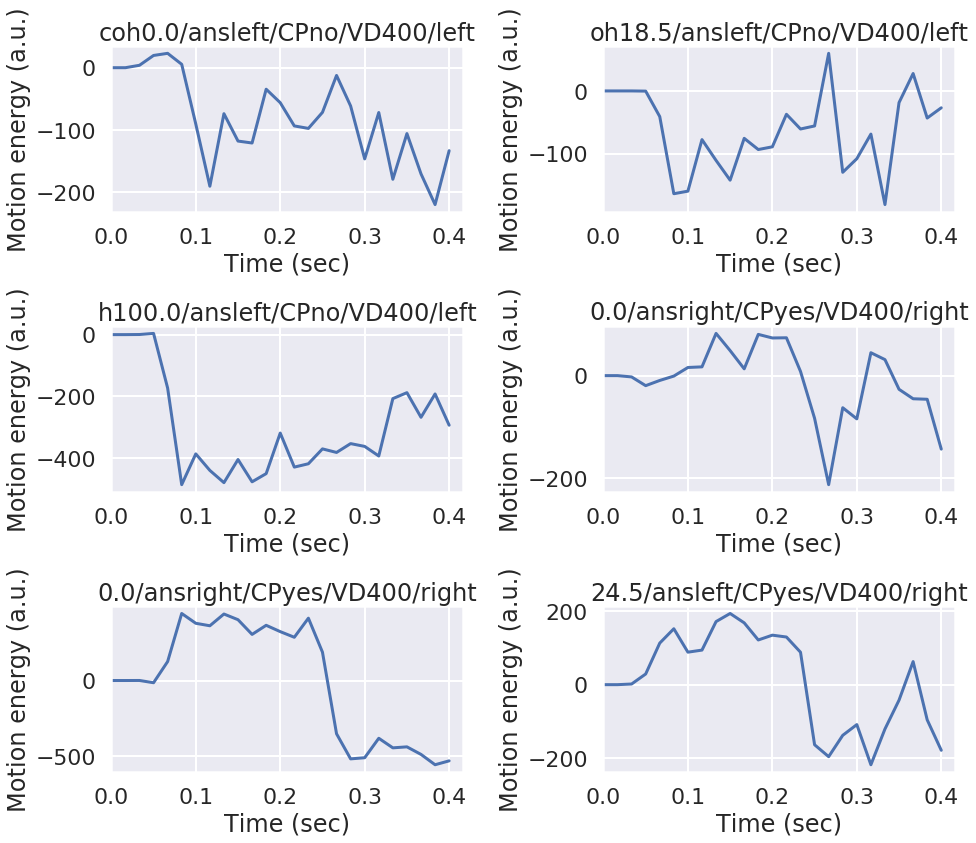

In [50]:
if not SKIP_BASIC_STEPS:
    plt.rcParams["figure.figsize"] = (14, 12) # (w, h) # figure size 
    subplot_shape = (3, 2)
    f, ax = plt.subplots(subplot_shape[0], subplot_shape[1], sharex=False)
    print(type(ax))
    num_frames = 25#attrs_dict['num_frames']
    num_trials = 6#len(trial_numbers)
    for trial_number in range(num_trials):
        # next two lines very inefficient/inelegant
    #     dots_curr_trial = dots_table[dots_table['trialCount'] == (trial + 2)] # TODO: this hard-coding is NOT ROBUST
    #     num_frames = max(dots_curr_trial['frameIdx'])

        t = kiani_me.filter_grid(num_frames, 1 / framerate)
        subplot_idx = np.unravel_index(trial_number, subplot_shape)
        if np.sum(subplot_shape):
#             print(subplot_idx)
            ax[subplot_idx].plot(t, dots_energy[trial_number].sum(axis=(0, 1)))
            ax[subplot_idx].set(xlim=(0, num_frames * (1 / framerate)), ylim=(None, None),
                                xlabel="Time (sec)",
                                ylabel="Motion energy (a.u.)", 
                                title=f"{group_names[trial_number][-30:]}")
        else:       
            ax.plot(t, dots_energy[trial_number].sum(axis=(0, 1)))
            ax.set(xlim=(0, num_frames * (1 / framerate)), ylim=(None, None),
                   xlabel="Time (sec)",
                   ylabel="Motion energy (a.u.)", 
                   title=f"{group_names[trial_number][-30:]}")
    f.tight_layout()
    print('Step 5 completed')
else:
    print('step 5 skipped')

# Sanity checks on motion energy

- display ME (averaged across trials), for a whole dataset, add stdev on top of mean.
- repeat the above for the opposite direction of motion (new dataset)
- repeat the above for several coherence levels  

**Steps**   
1. get motion energies in data frame
2. plot results with seaborn

With 100 trials, ME sould take, max, 2min to compute...

In [22]:
time_next_cell = 4
print(f"WARNING, THE NEXT CELL TAKES SOME TIME TO EXECUTE. LAST TIME IT TOOK {time_next_cell} MINUTES")

WARNING, THE NEXT CELL TAKES SOME TIME TO EXECUTE. LAST TIME IT TOOK 4 MINUTES


In [54]:
# %%time
RUN = True
if RUN:
    print(f"applying filters to {len(dset_names)} datasets")
    df_list=[]
    for (dsetname, gname) in zip(dset_names, group_names):
        trial_list = range(1, database_info[dsetname[1:]]['shape'][0] + 1)
        df_list.append(my_me.compute_motion_energy_for_trials_in_db(file_path, dsetname[1:], gname[1:], 
                                                                    trial_list, filters, create_dsetid=False)) 
else:
    print(f"As a safeguard, this cell didn't execute. Set the RUN variable to True if you really want to execute it.")

applying filters to 6 datasets


AssertionError: 

In [17]:
# concatenate all dataframes together
# %%time # for some reason this line throws an error
print(f"aggregate all data frames into a single one")
agg_df = pd.concat(df_list)

aggregate all data frames into a single one


In [46]:
print("INFO ABOUT AGGREGATE DATA FRAME")
agg_df.info()

INFO ABOUT AGGREGATE DATA FRAME
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3331 entries, 0 to 152
Data columns (total 8 columns):
ME           3331 non-null float64
coherence    3331 non-null int64
density      3331 non-null int64
direction    3331 non-null object
dsetID       3331 non-null object
filtersID    3331 non-null object
time         3331 non-null float64
trial        3331 non-null int64
dtypes: float64(2), int64(3), object(3)
memory usage: 314.2+ KB


In [24]:
import re

In [26]:
ansleft_pattern = r"ansleft"
probCP_low_pattern = r"probCP0.1"
subj_patterns = [r"subj" + str(pilotID) for pilotID in range(15,20)]
print(subj_patterns)

['subj15', 'subj16', 'subj17', 'subj18', 'subj19']


In [33]:
agg_df.shape

(3331, 8)

In [47]:
a=agg_df["dsetID"].values[0]
print(a)

subj15/probCP0.1/coh0/ansleft/CPno/VD400/px


In [48]:
type(a)

str

In [50]:
newcol_names = ['ansdir', 'subject', 'probCP']
ansdir, subject, probCP = [], [], []
for r in range(agg_df.shape[0]):
    dset_name = agg_df['dsetID'].values[r]
    ans_match = re.search(ansleft_pattern, dset_name)
    prob_match = re.search(probCP_low_pattern, dset_name)
    subj_matches = [re.search(subj_pattern, dset_name) for subj_pattern in subj_patterns]
    
    if ans_match:
        ansdir.append('left')
    else:
        ansdir.append('right')
        
    if prob_match:
        probCP.append(0.1)
    else:
        probCP.append(0.5)
        
    for subj in range(len(subj_matches)):
        subj_match = subj_matches[subj]
        if subj_match:
            subject.append(subj + 15)
assert len(ansdir) == len(subject) == len(probCP)

In [51]:
assert len(ansdir) == agg_df.shape[0]

In [52]:
agg_df["ansdir"] = ansdir
agg_df["subject"] = subject
agg_df["probCP"] = probCP

In [53]:
agg_df.head()

,ME,coherence,density,direction,dsetID,filtersID,time,trial,ansdir,subject,probCP
0,-7.324407e-29,0,90,left,subj15/probCP0.1/coh0/ansleft/CPno/VD400/px,32_32_11_32_32_11_32_32_11_32_32_11,0.000000,1,left,15,0.1
1,2.088703e-13,0,90,left,subj15/probCP0.1/coh0/ansleft/CPno/VD400/px,32_32_11_32_32_11_32_32_11_32_32_11,0.016667,1,left,15,0.1
2,3.921383e+00,0,90,left,subj15/probCP0.1/coh0/ansleft/CPno/VD400/px,32_32_11_32_32_11_32_32_11_32_32_11,0.033333,1,left,15,0.1
3,4.408437e+02,0,90,left,subj15/probCP0.1/coh0/ansleft/CPno/VD400/px,32_32_11_32_32_11_32_32_11_32_32_11,0.050000,1,left,15,0.1
4,3.171246e+02,0,90,left,subj15/probCP0.1/coh0/ansleft/CPno/VD400/px,32_32_11_32_32_11_32_32_11_32_32_11,0.066667,1,left,15,0.1


In [20]:
print(f"number of rows in data frame: {len(agg_df)}")

number of rows in data frame: 3331


In [21]:
FILL_DSET_ID_MANUALLY = False
if FILL_DSET_ID_MANUALLY: 
    # since my_me.compute_motion_energy_for_trials_in_db() doesn't yet assign dataset index correctly, I do it manually
    dsetID_col = 4

    rows_per_dset = 600
    num_dsets = len(dset_names)

    assert len(agg_df) == num_dsets * rows_per_dset

    idx_low, idx_up = 0, 0

    for dset_idx in range(num_dsets):
        idx_up += rows_per_dset
        agg_df.iloc[idx_low:idx_up,dsetID_col] = 'dset' + str(dset_idx)
        idx_low = idx_up

In [23]:
SAVE_DATAFRAME = False
file_path = 'motion_energy_pilot_v3.csv'
if SAVE_DATAFRAME:
    agg_df.to_csv(file_path, index=False)

In [ ]:
LOAD_DATA_FRAME = False  # if true, should load csv file dumped in previous cell

# somehow in this cell I had to call again these 3 commands
plt.rcParams["figure.figsize"] = (16, 25) # (w, h) # figure size 

with sns.axes_style("white"):
    g = sns.FacetGrid(agg_df, row="coherence", col="direction", margin_titles=True, height=4, aspect=2.5)
g.map(sns.lineplot, "time", "ME", ci="sd");
g.set_axis_labels("time (sec)", "ME");
# g.set(xticks=[10, 30, 50], yticks=[2, 6, 10]);
# g.fig.subplots_adjust(wspace=20, hspace=.2);

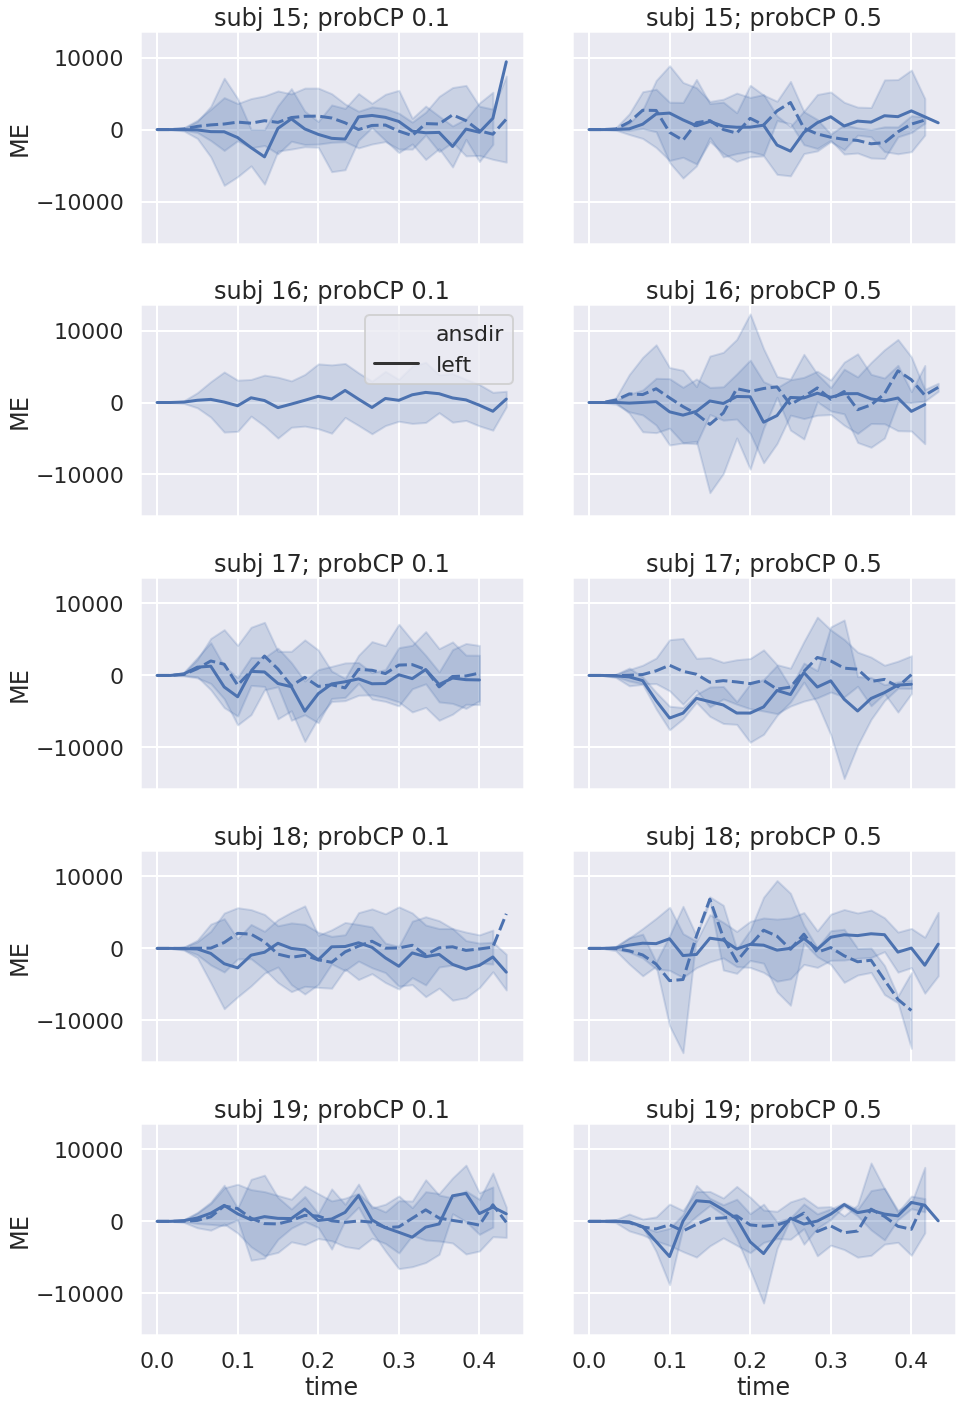

In [65]:
# same data, but overlayed on single plot
# nice ref:
# https://seaborn.pydata.org/generated/seaborn.lineplot.html
f, axarr = plt.subplots(5, 2, sharex=True, sharey=True)

plt.rcParams["figure.figsize"] = (14, 20) # (w, h) # figure size 

palette = sns.color_palette("mako_r", 3)
probCPs=[.1,.5]

# Plot the responses for different events and regions
for subj in range(5):
    for prob in range(2):
        subject = subj + 15
        probCP = probCPs[prob]
        leg = "brief" if (subj==1 and prob==0) else False
        sns.lineplot(x="time", y="ME",
                     data=agg_df[(agg_df["subject"]==subject) & (agg_df["probCP"]==probCP)],
                     style="ansdir",
                     palette=palette,
                     ci="sd", 
                     legend=leg,
                     ax=axarr[subj, prob])
        axarr[subj, prob].set_title(f'subj {subject}; probCP {probCP}')
for row in range(4):
    plt.setp([a.get_xticklabels() for a in axarr[row, :]], visible=False)
plt.setp([a.get_yticklabels() for a in axarr[:, 1]], visible=False)
plt.tight_layout()
#         axarr[subj, prob].legend(loc='upper left')